In [110]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt

In [111]:
# データを読み込む
data_dir = '../Mining_DATA/Formatted_DATA/'

# AAPL.csvを読み込む
aapl_path = os.path.join(data_dir, 'AAPL.csv')
aapl_data = pd.read_csv(aapl_path)
aapl_data = aapl_data[['Date', 'Open']]

# AAPL.csv以外のcsvファイルのリストを取得
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and f != 'AAPL.csv']

# データフレームのリスト
data_list = []

# 各CSVファイルを読み込み、DateとOpen列を選択
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    df = df[['Date', 'Open']]
    # カラム名をユニークにするためにファイル名を追加
    df.rename(columns={'Open': f'Open_{file[:-4]}'}, inplace=True)
    data_list.append(df)

# 他の株のOpen値をマージ
merged_data = aapl_data
for df in data_list:
    merged_data = pd.merge(merged_data, df, on='Date', how='inner')

# 日付でソート
merged_data.sort_values('Date', inplace=True)

# 欠損値の処理
merged_data.dropna(inplace=True)

# 特徴量と目的変数の設定
X = merged_data.drop(columns=['Date', 'Open'])
y = merged_data['Open']

window_size = 10

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X.iloc[i-window_size:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

# X用のスケーラー
scaler_X = StandardScaler()

# y用のスケーラー
scaler_y = StandardScaler()

# シーケンスを作成
X_seq, y_seq = create_sequences(X, y, window_size)

# データをtrainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Xのスケーリング
X_train_shape = X_train.shape
X_train = X_train.reshape(-1, X_train.shape[2])
X_train = scaler_X.fit_transform(X_train)
X_train = X_train.reshape(X_train_shape)

X_test_shape = X_test.shape
X_test = X_test.reshape(-1, X_test.shape[2])
X_test = scaler_X.transform(X_test)
X_test = X_test.reshape(X_test_shape)

# yのスケーリング
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))
# シンプルなLSTMモデルの作成
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# 早期停止の設定
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# モデルの学習
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# 予測
y_pred_scaled = model.predict(X_test)

# 予測を元のスケールに戻す
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# 精度評価
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("===test===")
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

y_train_pred_scaled = model.predict(X_train)

# 予測を元のスケールに戻す
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_original = scaler_y.inverse_transform(y_train)

# 精度評価
mse = mean_squared_error(y_train_original, y_train_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train_original, y_train_pred)
r2 = r2_score(y_train_original, y_train_pred)

print("===train===")
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

Epoch 1/100
44/44 [==============================] - 2s 17ms/step - loss: 0.1123 - val_loss: 1.9714
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0423 - val_loss: 1.4234
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 1.0970
Epoch 4/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0294 - val_loss: 0.9019
Epoch 5/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0244 - val_loss: 0.7939
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.7128
Epoch 7/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.5958
Epoch 8/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.5381
Epoch 9/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.4901
Epoch 10/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.4789
Epoch 11

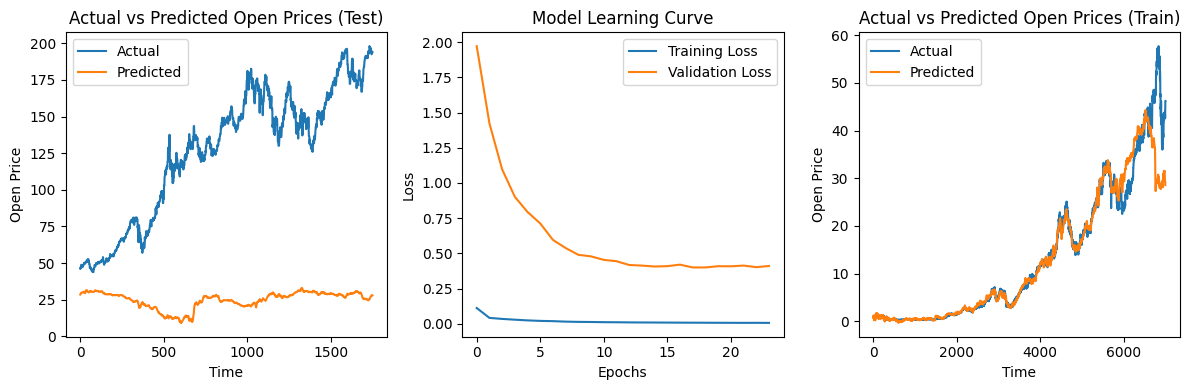

In [112]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# 1つ目のプロット: Actual vs Predicted Open Prices (Test)
axs[0].plot(y_test_original, label='Actual')
axs[0].plot(y_pred, label='Predicted')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Open Price')
axs[0].set_title('Actual vs Predicted Open Prices (Test)')
axs[0].legend()

# 2つ目のプロット: Model Learning Curve
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Model Learning Curve')
axs[1].legend()

# 3つ目のプロット: Actual vs Predicted Open Prices (Train)
axs[2].plot(y_train_original, label='Actual')
axs[2].plot(y_train_pred, label='Predicted')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Open Price')
axs[2].set_title('Actual vs Predicted Open Prices (Train)')
axs[2].legend()

plt.tight_layout()
plt.show()